<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Требуется чтобы значение MAE на тестовой выборке было не больше 8.

## Исследовательский анализ данных

In [1]:
# Импортируем библиотеки
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn

In [2]:
# Загрузим данные
labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='https://code.s3.yandex.net/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


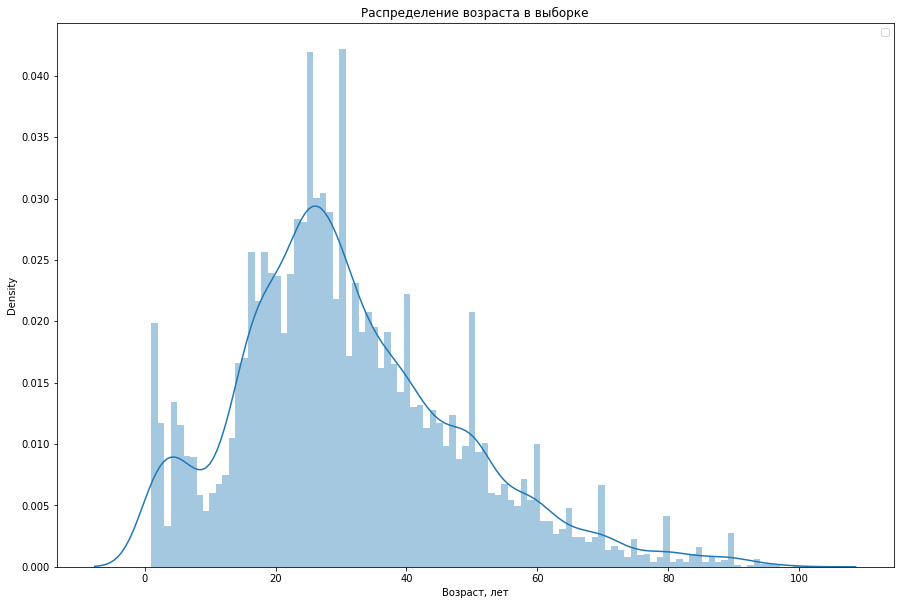

In [4]:
plt.figure(figsize=(15,10))
seaborn.distplot(labels["real_age"],  hist = True, bins=100)
plt.xlabel("Возраст, лет")
plt.title("Распределение возраста в выборке")
plt.legend('')
plt.show()

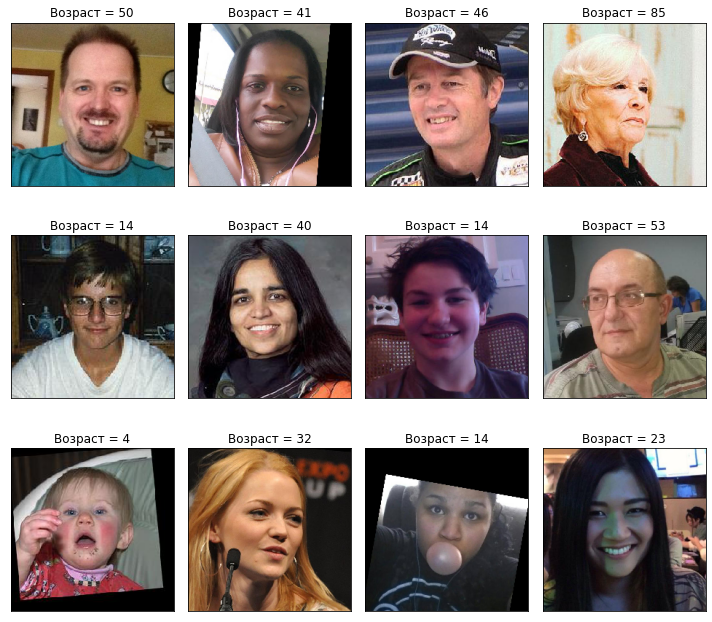

In [5]:
# посмотрим 12 изображений
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.title('Возраст = '+ str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**

Мы имеем 7591 фотографий людей в возрасте от года до 100 лет со средним значением в 31 год и медианой в 17 лет.

Изображения уже подготовленны. На изображеениях уже провден face detection. В теории аугментацию проводить не нужно, но мы это проверим.

## Обучение модели

Мы обучим модель на данных с различными параметрами. 

1. размер изображний 150 на 150, 32 изображения на батч
2. к прдыдущему добавляем отражения по горизонтали и вертикали
3. размер изображний 224 на 224, 32 изображения на батч
4. размер изображний 224 на 224, 64 изображения на батч
5. размер изображний 224 на 224, 16 изображения на батч


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

**Тест #1**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-03-25 06:25:49.363255: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-25 06:25:59.857475: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 162s - loss: 251.3081 - mae: 11.4999 - val_loss: 1018.4193 - val_mae: 27.2311
Epoch 2/10
178/178 - 35s - loss: 65.0130 - mae: 6.1247 - val_loss: 817.6036 - val_mae: 23.6011
Epoch 3/10
178/178 - 35s - loss: 29.8137 - mae: 4.2227 - val_loss: 531.9371 - val_mae: 18.2332
Epoch 4/10
178/178 - 35s - loss: 18.5749 - mae: 3.3060 - val_loss: 149.1039 - val_mae: 9.1271
Epoch 5/10
178/178 - 35s - loss: 13.3860 - mae: 2.7974 - val_loss: 95.5812 - val_mae: 7.3120
Epoch 6/10
178/178 - 35s - loss: 10.1931 - mae: 2.4410 - val_loss: 80.9457 - val_mae: 6.6281
Epoch 7/10
178/178 - 35s - loss: 8.8388 - mae: 2.2596 - val_loss: 72.2590 - val_mae: 6.4935
Epoch 8/10
178/178 - 35s - loss: 7.3582 - mae: 2.0474 - val_loss: 71.7223 - val_mae: 6.4552
Epoch 9/10
178/178 - 35s - loss: 6.4657 - mae: 1.9248 - val_loss: 73.3273 - val_mae: 6.4669
Epoch 10/10
178/178 - 34s - loss: 5.8095 - mae: 1.8120 - val_loss: 75.6689 - val_mae: 6.4232
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 75.6689 - mae: 6.4232
Test MAE: 6.4232

```
**Тест #2**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-03-25 08:09:20.559991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-25 08:09:20.856119: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 43s - loss: 309.1871 - mae: 12.8932 - val_loss: 853.8119 - val_mae: 24.3129
Epoch 2/10
178/178 - 35s - loss: 111.9989 - mae: 8.0574 - val_loss: 697.2279 - val_mae: 21.1972
Epoch 3/10
178/178 - 35s - loss: 87.1168 - mae: 7.0905 - val_loss: 368.1840 - val_mae: 14.6124
Epoch 4/10
178/178 - 35s - loss: 67.8451 - mae: 6.2546 - val_loss: 182.5517 - val_mae: 10.7548
Epoch 5/10
178/178 - 35s - loss: 55.6758 - mae: 5.6929 - val_loss: 112.4888 - val_mae: 8.0649
Epoch 6/10
178/178 - 35s - loss: 46.8758 - mae: 5.2230 - val_loss: 86.7392 - val_mae: 7.0692
Epoch 7/10
178/178 - 35s - loss: 39.0373 - mae: 4.7487 - val_loss: 87.8024 - val_mae: 6.9921
Epoch 8/10
178/178 - 35s - loss: 32.1966 - mae: 4.3333 - val_loss: 82.7650 - val_mae: 6.8074
Epoch 9/10
178/178 - 35s - loss: 30.1503 - mae: 4.1204 - val_loss: 79.6141 - val_mae: 6.5880
Epoch 10/10
178/178 - 35s - loss: 25.5361 - mae: 3.8505 - val_loss: 77.6347 - val_mae: 6.5649
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 77.6347 - mae: 6.5649
Test MAE: 6.5649

```
**Тест #3**

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-03-25 04:57:51.779151: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-25 04:57:52.074862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 288.7254 - mae: 12.1370 - val_loss: 958.8962 - val_mae: 26.2053
Epoch 2/10
178/178 - 37s - loss: 69.3414 - mae: 6.3037 - val_loss: 638.8747 - val_mae: 20.0162
Epoch 3/10
178/178 - 37s - loss: 34.3484 - mae: 4.4994 - val_loss: 213.2218 - val_mae: 10.8483
Epoch 4/10
178/178 - 37s - loss: 19.3013 - mae: 3.3689 - val_loss: 110.3916 - val_mae: 8.0486
Epoch 5/10
178/178 - 37s - loss: 12.8277 - mae: 2.7875 - val_loss: 90.5868 - val_mae: 7.2088
Epoch 6/10
178/178 - 37s - loss: 10.1099 - mae: 2.4263 - val_loss: 72.6737 - val_mae: 6.4652
Epoch 7/10
178/178 - 37s - loss: 9.1063 - mae: 2.3123 - val_loss: 67.7580 - val_mae: 6.1841
Epoch 8/10
178/178 - 38s - loss: 9.1025 - mae: 2.2788 - val_loss: 73.2045 - val_mae: 6.4505
Epoch 9/10
178/178 - 37s - loss: 8.5055 - mae: 2.2163 - val_loss: 68.3893 - val_mae: 6.3337
Epoch 10/10
178/178 - 37s - loss: 7.2602 - mae: 2.0333 - val_loss: 69.5340 - val_mae: 6.3395
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 69.5340 - mae: 6.3395
Test MAE: 6.3395

```
**Тест #4**

```
Train for 89 steps, validate for 30 steps
Epoch 1/10
2022-03-25 05:11:12.326991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-25 05:11:16.051132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
89/89 - 143s - loss: 487.4853 - mae: 16.3931 - val_loss: 1156.8189 - val_mae: 29.6162
Epoch 2/10
89/89 - 39s - loss: 78.4571 - mae: 6.6821 - val_loss: 1118.6972 - val_mae: 28.9717
Epoch 3/10
89/89 - 39s - loss: 33.5023 - mae: 4.4221 - val_loss: 884.5151 - val_mae: 24.9208
Epoch 4/10
89/89 - 39s - loss: 16.9695 - mae: 3.2058 - val_loss: 836.0401 - val_mae: 24.0293
Epoch 5/10
89/89 - 39s - loss: 12.5156 - mae: 2.7453 - val_loss: 636.6795 - val_mae: 20.3370
Epoch 6/10
89/89 - 39s - loss: 10.6359 - mae: 2.4822 - val_loss: 349.0136 - val_mae: 14.1139
Epoch 7/10
89/89 - 40s - loss: 9.9104 - mae: 2.3937 - val_loss: 257.6331 - val_mae: 12.2659
Epoch 8/10
89/89 - 39s - loss: 8.6404 - mae: 2.2353 - val_loss: 189.8404 - val_mae: 10.5632
Epoch 9/10
89/89 - 40s - loss: 8.3883 - mae: 2.2152 - val_loss: 98.7926 - val_mae: 7.5105
Epoch 10/10
89/89 - 40s - loss: 7.9020 - mae: 2.1606 - val_loss: 81.6185 - val_mae: 6.8351
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
30/30 - 10s - loss: 81.6185 - mae: 6.8351
Test MAE: 6.8351

```
**Тест #5**

```
Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-03-25 05:22:11.230978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-25 05:22:11.541052: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 47s - loss: 195.4022 - mae: 10.2387 - val_loss: 792.6577 - val_mae: 23.2164
Epoch 2/10
356/356 - 38s - loss: 66.6347 - mae: 6.2838 - val_loss: 279.6738 - val_mae: 12.6884
Epoch 3/10
356/356 - 38s - loss: 37.2060 - mae: 4.7193 - val_loss: 72.2098 - val_mae: 6.4286
Epoch 4/10
356/356 - 38s - loss: 24.8026 - mae: 3.8682 - val_loss: 73.7155 - val_mae: 6.5822
Epoch 5/10
356/356 - 38s - loss: 17.4778 - mae: 3.2075 - val_loss: 68.5298 - val_mae: 6.3041
Epoch 6/10
356/356 - 38s - loss: 15.4539 - mae: 3.0039 - val_loss: 71.1261 - val_mae: 6.4502
Epoch 7/10
356/356 - 38s - loss: 13.0912 - mae: 2.7788 - val_loss: 89.2838 - val_mae: 7.0580
Epoch 8/10
356/356 - 38s - loss: 11.4715 - mae: 2.5454 - val_loss: 74.4961 - val_mae: 6.4014
Epoch 9/10
356/356 - 38s - loss: 10.4331 - mae: 2.4574 - val_loss: 80.1811 - val_mae: 6.6301
Epoch 10/10
356/356 - 38s - loss: 10.4396 - mae: 2.4397 - val_loss: 65.9464 - val_mae: 6.1763
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 65.9464 - mae: 6.1763
Test MAE: 6.1763

```

Тест #5 с параметрами: "размер изображний 224 на 224, 16 изображения на батч и 10 эпох" показал себя лучше всего cо средней абсолютной ошибкой равной 6,1763. В среднем данная модель ошибается на 6 лет.

## Анализ обученной модели

Лучше значения MAE для каждого теста сведем в 1 таблицу

                  MAE	 Эпоха     Время обучения   Параметеры
    Тест №1 	6.4232	  10          476 сек       размер изображний 150 на 150, 32 изображения на батч
    Тест №2 	6.5649	  10          358 сек       +отражения по горизонтали и вертикали
    Тест №3     6.1841       7          267 сек       размер изображний 224 на 224, 32 изображения на батч
    Тест №4     6.8351      10          494 сек       размер изображний 224 на 224, 64 изображения на батч
    Тест №5     6.1763      10          389 сек       размер изображний 224 на 224, 16 изображения на батч
    
Данные уже обработаны, их количество велико, поэтому не требуется аугментация. 

При уменьшении размера изображений мы теряем данные, что сказывается на качестве моделей. Модель начинает предсказывать хуже.
Аугментация также портит качество предсказываний на малом количестве эпох, однако обучение проходит быстрее и переобучение ниже.
Размер батча странно влияет на обучение, самая высокая скорость у батча размером в 32 изображения, а самая медленная у батча размером в 64. Также модели с батчами в 64 изображения не достаточно 10 эпох.

Для запуска в работу лучше использовать модель, обученную на данных с размером изображения 224 на 224 пикселя, 32мя изображениями на батч и 7 эпохами. Так как высокая скорость при хорошем качестве. У данной модели MAE = 6.1841, а по заданию не выше 8.